In [410]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import umap.umap_ as umap
import cv2

In [411]:
# Function to load MNIST images from idx file
def load_idx_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack('>IIII', f.read(16))  # Read metadata
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols, 1)  # Read images
    return data.astype(np.float32) / 255.0  # Normalize between 0 and 1

# Function to load MNIST labels from idx file
def load_idx_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack('>II', f.read(8))  # Read metadata
        labels = np.frombuffer(f.read(), dtype=np.uint8)  # Read labels
    return labels

In [412]:
# Load train and test data
train_images = load_idx_images("train-images.idx3-ubyte")
train_labels = load_idx_labels("train-labels.idx1-ubyte")
test_images = load_idx_images("t10k-images.idx3-ubyte")
test_labels = load_idx_labels("t10k-labels.idx1-ubyte")

# Print dataset shapes
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (60000, 28, 28, 1)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28, 1)
Test Labels Shape: (10000,)


In [413]:
# Define Convolutional Autoencoder
encoder = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(512, (3,3), activation='relu', padding='same'),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
])

decoder = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(64,)),
    layers.Dense(7*7*512, activation='relu'),
    layers.Reshape((7, 7, 512)),  

    layers.Conv2DTranspose(256, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same'),
    layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')  # Output
])

# Combine Encoder & Decoder into an Autoencoder
autoencoder = models.Sequential([encoder, decoder])

# Compile Autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()  # Print model summary
encoder.summary()
decoder.summary()

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_102 (Sequential)     │ (None, 64)             │    14,428,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_103 (Sequential)     │ (None, 28, 28, 1)      │    14,452,737 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,880,961 (110.17 MB)

 Trainable params: 28,880,961 (110.17 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_159 (Conv2D)             │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_162 (Conv2D)             │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 64)             │        32,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,428,224 (55.04 MB)

 Trainable params: 14,428,224 (55.04 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_170 (Dense)               │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 25088)          │    12,870,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_34 (Reshape)            │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_173            │ (None, 7, 7, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_53 (UpSampling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_174            │ (None, 14, 14, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_54 (UpSampling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_175            │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_176            │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,452,737 (55.13 MB)

 Trainable params: 14,452,737 (55.13 MB)

 Non-trainable params: 0 (0.00 B)

In [414]:
# Train Autoencoder (Unsupervised Learning)
autoencoder.fit(train_images, train_images, epochs=20, batch_size=32, shuffle=True)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 508s 269ms/step - loss: 0.1802
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 505s 269ms/step - loss: 0.0812
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 505s 269ms/step - loss: 0.0764
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 511s 273ms/step - loss: 0.0742
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 507s 270ms/step - loss: 0.0727
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 526s 280ms/step - loss: 0.0718
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 526s 281ms/step - loss: 0.0709
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 514s 274ms/step - loss: 0.0703
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 525s 280ms/step - loss: 0.0699
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 515s 274ms/step - loss: 0.0693
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1434s 765ms/step - loss: 0.0689
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 495s 264ms/step - loss: 0.0688
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 946s 505ms/step - loss: 0.0684
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 508

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


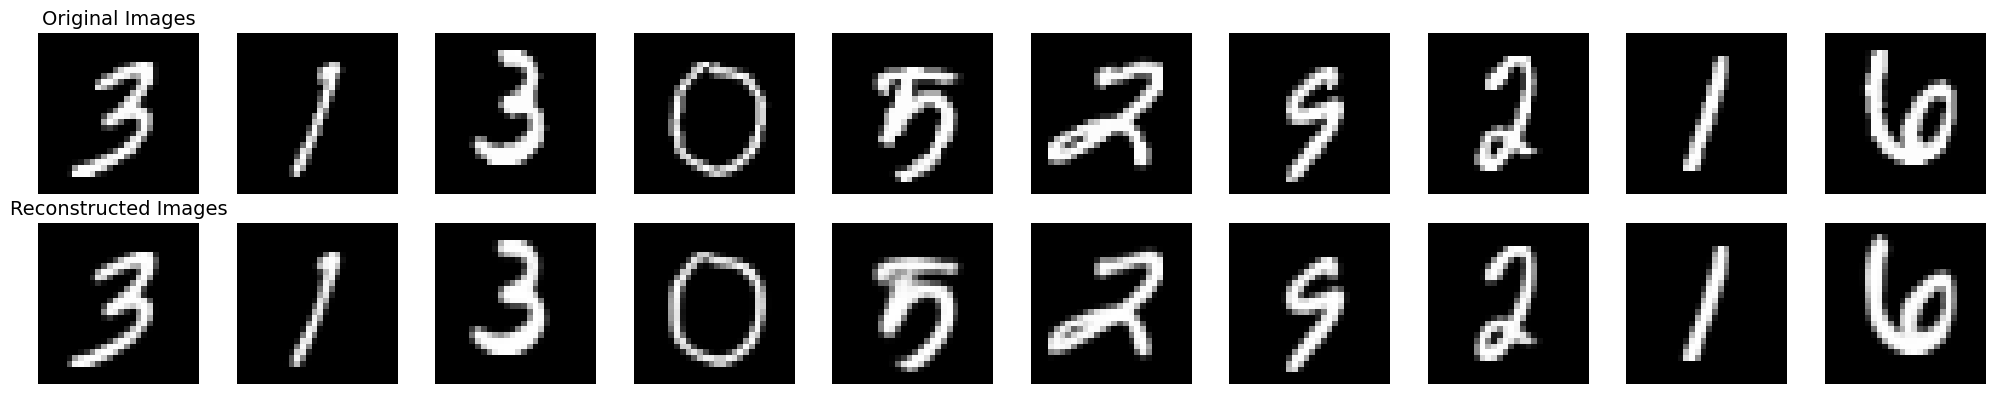

In [415]:
# Select random images from the dataset
num_images = 10  # Number of images to display
random_indices = np.random.choice(len(train_images), num_images, replace=False)

# Encode and decode the images
encoded_imgs = encoder.predict(train_images[random_indices])  # Pass through encoder
decoded_imgs = decoder.predict(encoded_imgs)  # Pass through decoder

# Plot the images: original vs. reconstructed
fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

for i in range(num_images):
    # Original images
    axes[0, i].imshow(train_images[random_indices[i]].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original Images", fontsize=14)
axes[1, 0].set_title("Reconstructed Images", fontsize=14)
plt.tight_layout()
plt.show()

In [441]:
# Extract Features Using Encoder
encoded_train = encoder.predict(train_images)
encoded_test = encoder.predict(test_images)

# Reduce to 5D using UMAP
umap_5d = umap.UMAP(n_components=8, random_state=42)
encoded_train_5d = umap_5d.fit_transform(encoded_train)
encoded_test_5d = umap_5d.transform(encoded_test)

num_clusters = 10  # Adjust based on variation in styles
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
gmm.fit(encoded_train_5d)

# Assign clusters to training and test data
train_clusters = gmm.predict(encoded_train_5d)
test_clusters = gmm.predict(encoded_test_5d)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 359s 192ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 217ms/step


c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\dcies\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [442]:
from scipy.stats import mode

# Assign labels to clusters based on most frequent digit
def assign_labels(clusters, true_labels):
    label_map = {}
    for i in range(num_clusters):
        mask = (clusters == i)  # Select points in cluster i
        if np.sum(mask) == 0:
            label_map[i] = -1  # No samples in cluster
        else:
            most_common = mode(true_labels[mask])[0]  # Most frequent digit
            label_map[i] = most_common
    return label_map

cluster_to_label = assign_labels(train_clusters, train_labels)
predicted_labels = np.array([cluster_to_label[c] for c in test_clusters])

# Evaluate Clustering Performance
accuracy = np.mean(predicted_labels == test_labels)
print(f"GMM Classification Accuracy: {accuracy * 100:.2f}%")


GMM Classification Accuracy: 97.04%


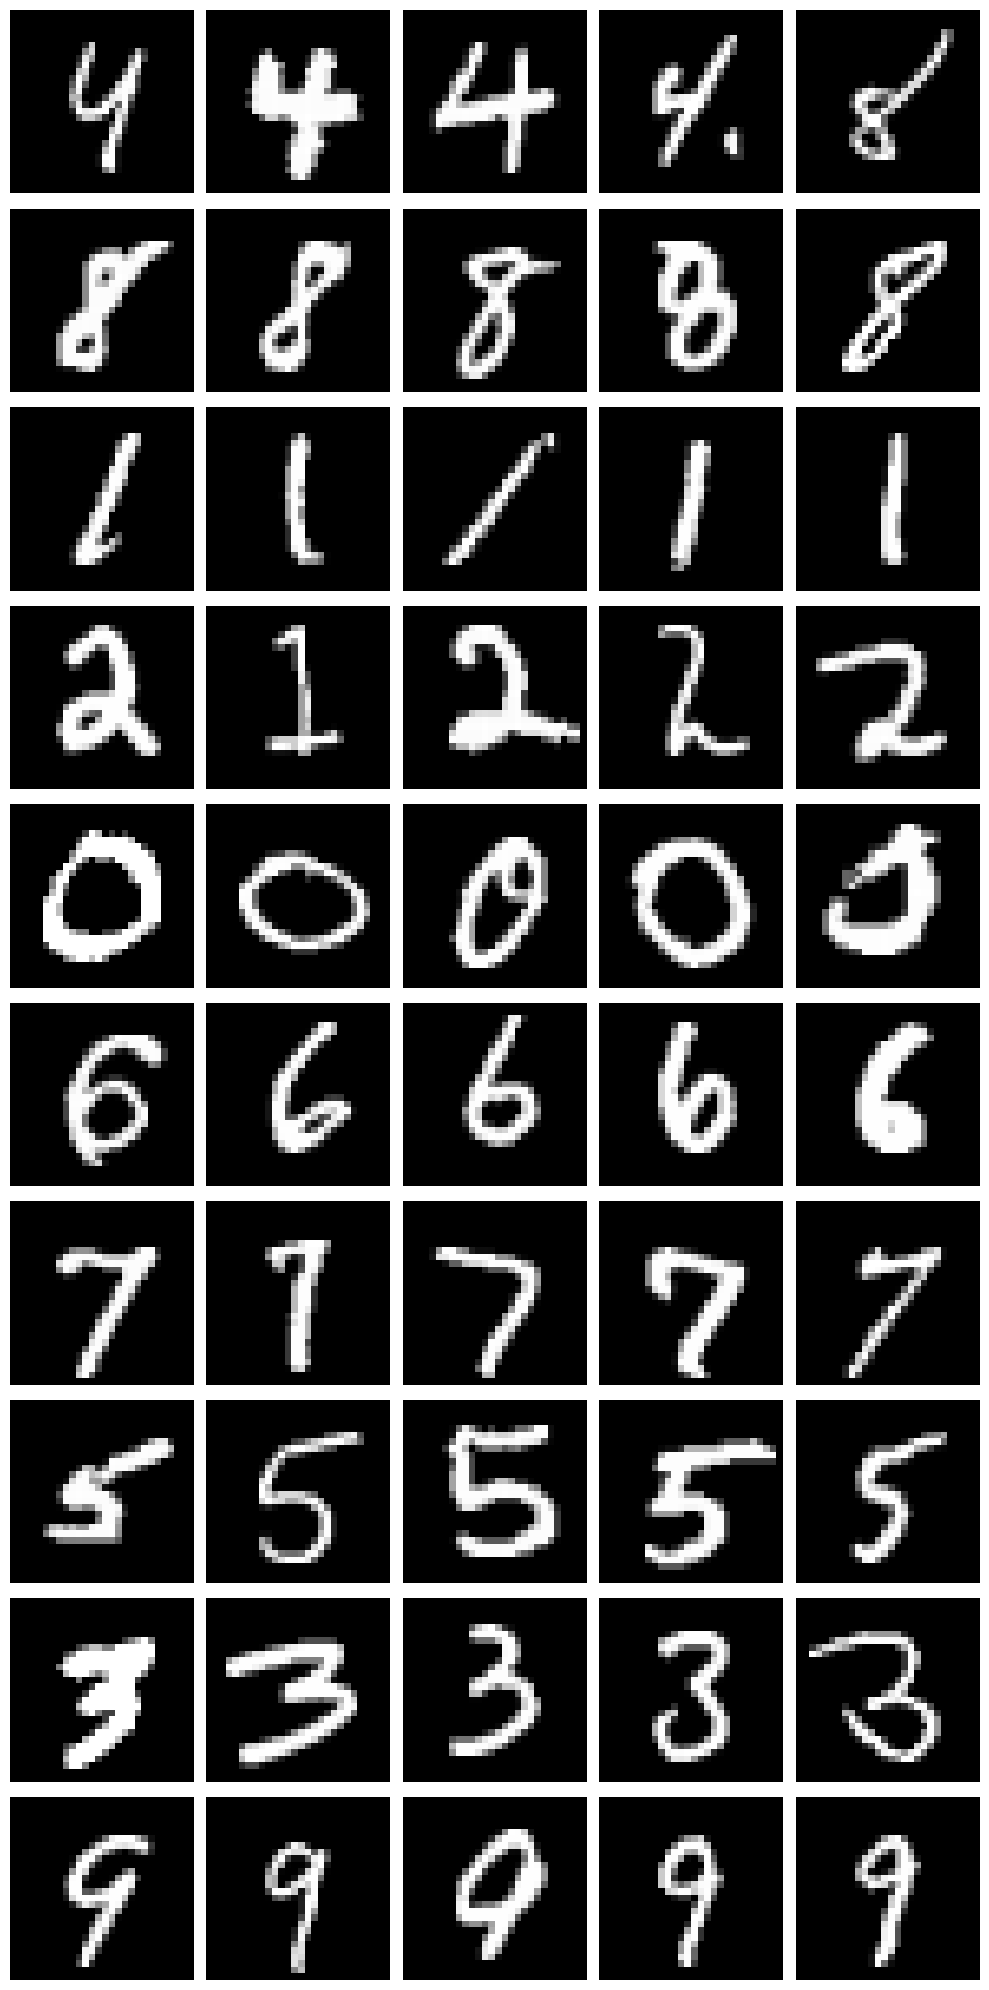

In [443]:
# Function to plot samples from each cluster
def plot_cluster_samples(images, cluster_labels, num_samples=5):
    unique_clusters = np.unique(cluster_labels)
    fig, axes = plt.subplots(len(unique_clusters), num_samples, figsize=(num_samples * 2, len(unique_clusters) * 2))
    
    for i, cluster in enumerate(unique_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        selected_indices = np.random.choice(cluster_indices, min(num_samples, len(cluster_indices)), replace=False)
        
        for j, img_idx in enumerate(selected_indices):
            axes[i, j].imshow(images[img_idx].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display images
plot_cluster_samples(train_images, train_clusters, num_samples=5)

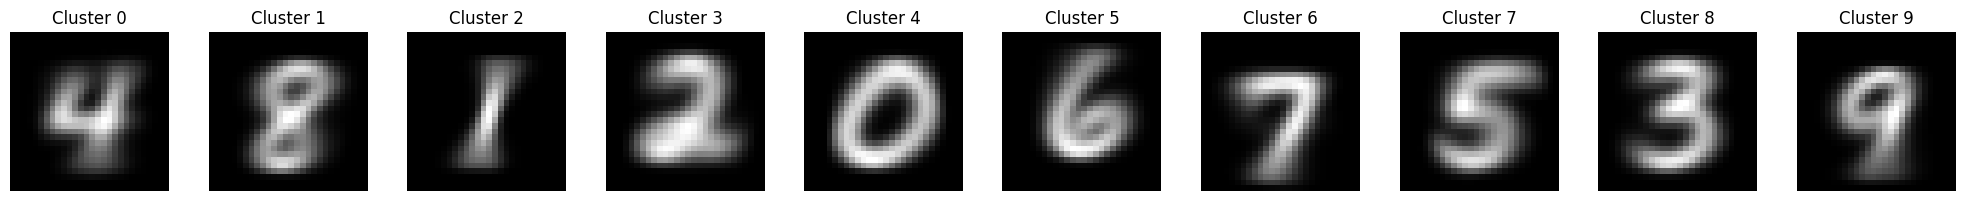

In [444]:
def plot_average_images(images, cluster_labels, num_clusters):
    
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 2, 2))

    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices for the cluster
        if len(cluster_indices) > 0:
            avg_image = np.mean(images[cluster_indices], axis=0)  # Compute mean image
        else:
            avg_image = np.zeros_like(images[0])  # Handle empty clusters

        axes[cluster].imshow(avg_image.reshape(28, 28), cmap='gray')
        axes[cluster].axis('off')
        axes[cluster].set_title(f"Cluster {cluster}")

    plt.tight_layout()
    plt.show()

# Call function to display average images from clusters
plot_average_images(train_images, train_clusters, num_clusters)

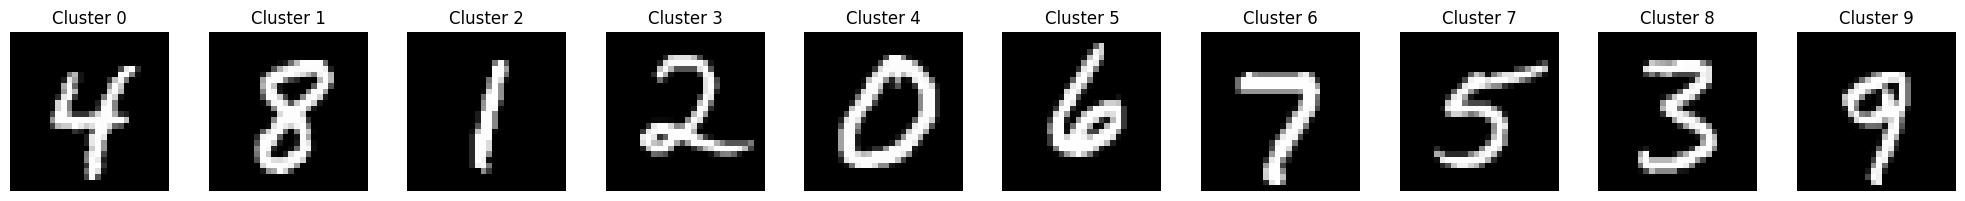

In [445]:
from scipy.spatial.distance import cdist

def find_representative_images(encoded_images, images, cluster_labels, num_clusters):
    """
    Finds and plots the most representative image from each cluster.
    """
    representative_images = []

    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]  # Get indices for the cluster
        if len(cluster_indices) == 0:
            representative_images.append(np.zeros_like(images[0]))  # Empty cluster placeholder
            continue

        cluster_features = encoded_images[cluster_indices]  # Get encoded features for cluster
        centroid = np.mean(cluster_features, axis=0)  # Compute centroid
        distances = cdist([centroid], cluster_features, metric="euclidean")  # Compute distances
        closest_index = cluster_indices[np.argmin(distances)]  # Find closest image index

        representative_images.append(images[closest_index])  # Store representative image

    # Plot representative images
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 2, 2))
    for i in range(num_clusters):
        axes[i].imshow(representative_images[i].reshape(28, 28), cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"Cluster {i}")

    plt.tight_layout()
    plt.show()

# Call function to display representative images
find_representative_images(encoded_train, train_images, train_clusters, num_clusters)

In [ ]:
# Reduce from 5D to 3D for visualization
tsne_3d = TSNE(n_components=3, random_state=42)
reduced_3d = tsne_3d.fit_transform(encoded_train_5d)

# Plot 3D scatter of clusters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_3d[:, 0], reduced_3d[:, 1], reduced_3d[:, 2], c=train_clusters, cmap='tab20', alpha=0.5)
plt.colorbar(scatter)
plt.title("3D t-SNE Visualization of Clusters")
plt.show()